In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from transformers import AutoModel
from transformers import AutoTokenizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc
from tqdm.auto import tqdm, trange

In [2]:
def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [3]:
df_train = pd.read_csv('../data/train_bin.csv')
df_test = pd.read_csv('../data/test_bin.csv')

In [4]:
df_train.head(2)

,index,text,target
0,6864,"в период, установленный для проведения ОЭ, осу...",1
1,11270,О проведении опытной эксплуатации программно-а...,1


In [5]:
df_train = df_train[(df_train['text'].isna()==False) & (df_train['text'] != 'РАСПОРЯЖЕНИЕ')]
df_test = df_test[(df_test['text'].isna()==False) & (df_test['text'] != 'РАСПОРЯЖЕНИЕ')]

df_train, _ = train_test_split(df_train, stratify=df_train['target'], test_size=0.9)
df_test, _ = train_test_split(df_test, stratify=df_test['target'], test_size=0.9)

In [6]:
df_train.shape

(2711, 3)

In [7]:
df_test.shape

(1161, 3)

In [8]:
pd.DataFrame(df_train.value_counts('target'))

,0
target,
1,2011
0,700


In [9]:
pd.DataFrame(df_test.value_counts('target'))

,0
target,
1,861
0,300


# Transformers experiments
## rubert-base-cased

In [10]:
model_name = "DeepPavlov_rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model_bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased").to(torch.device('cuda'))

In [11]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):
        
        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)
        
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [12]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   
            predictions = model(texts.to(device)).squeeze()
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            
    return np.mean(epoch_f1)

In [13]:
MAX_LEN = 512

In [14]:
train_texts = df_train['text'].values
id2label = {i:l for i,l in enumerate(set(df_train['target']))}
label2id = {l:i for i,l in id2label.items()}
train_targets = [label2id[l] for l in df_train['target']]

valid_texts = df_test['text'].values
id2label = {i:l for i,l in enumerate(set(df_test['target']))}
label2id = {l:i for i,l in id2label.items()}
valid_targets = [label2id[l] for l in df_test['target']]

In [15]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)

valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [16]:
import torch.nn as nn

class CLF(nn.Module):
    
    def __init__(self, pretrained_model, num_classes):
        super().__init__()          
        self.tokenizer = tokenizer 
        self.pretrained_model = pretrained_model
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_classes) 
        self.act = nn.LogSoftmax(1) 
        
#         for param in self.pretrained_model.parameters():
#             param.requires_grad = False
            
    def forward(self, texts):
        
        mask = (texts != tokenizer.pad_token_id).long()
        
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        dense_outputs=self.fc(self.drop(hidden[:,0] ))
        outputs=self.act(dense_outputs)
        
        return outputs

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-6)
criterion = nn.NLLLoss() 

model = model.to(device)
criterion = criterion.to(device)

In [18]:
f1s = []
f1s_eval = []
num_epochs = 3
for i in range(num_epochs):
    print(f'Epoch {i+1}')
    tr = train(model, training_generator, optimizer, criterion, 2000)
    f1s.append(tr)
    evl = evaluate(model, valid_generator, criterion)
    print('Train - ', tr, 'Eval - ', evl)
    f1s_eval.append(evl)
torch.save(model.state_dict(), f'../models/{model_name}')

Epoch 1
Train -  0.8452205882352941 Eval -  0.9957191780821918
Epoch 2
Train -  0.9933823529411765 Eval -  0.9965753424657534
Epoch 3
Train -  0.9948529411764706 Eval -  0.9965753424657534


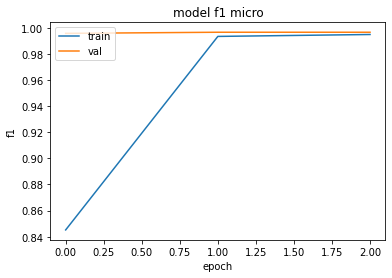

In [19]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
results_table = pd.DataFrame({'model': ['DeepPavlov/rubert-base-cased'],
                              'num_epochs': [num_epochs],
                              'F1': [f1s_eval[-1]]})
results_table

,model,num_epochs,F1
0,DeepPavlov/rubert-base-cased,3,0.996575


In [21]:
cleanup()

## xlm-roberta-base

In [22]:
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model_bert = AutoModel.from_pretrained("xlm-roberta-base").to(torch.device('cuda'))

In [23]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)

valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-6)
criterion = nn.NLLLoss() 

model = model.to(device)
criterion = criterion.to(device)

In [25]:
f1s = []
f1s_eval = []
num_epochs = 3
for i in range(num_epochs):
    print(f'Epoch {i+1}')
    tr = train(model, training_generator, optimizer, criterion, 2000)
    f1s.append(tr)
    evl = evaluate(model, valid_generator, criterion)
    print('Train - ', tr, 'Eval - ', evl)
    f1s_eval.append(evl)
torch.save(model.state_dict(), f'../models/{model_name}')

Epoch 1
Train -  0.7495273109243697 Eval -  0.9648972602739726
Epoch 2
Train -  0.9492647058823529 Eval -  0.9948630136986302
Epoch 3
Train -  0.9851890756302522 Eval -  0.9948630136986302


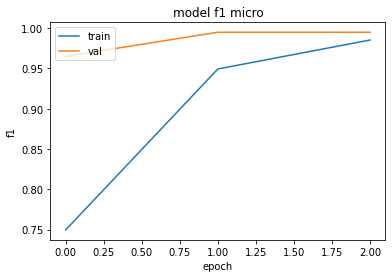

In [26]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
results_table.loc[results_table.shape[0]] = ['xlm-roberta-base', str(num_epochs), str(f1s_eval[-1])]
results_table

,model,num_epochs,F1
0,DeepPavlov/rubert-base-cased,3,0.996575
1,xlm-roberta-base,3,0.9948630136986302


In [28]:
cleanup()

## bert-base-multilingual-cased

In [29]:
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model_bert = AutoModel.from_pretrained("bert-base-multilingual-cased").to(torch.device('cuda'))

In [30]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)

valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-6)
criterion = nn.NLLLoss() 

model = model.to(device)
criterion = criterion.to(device)

In [32]:
f1s = []
f1s_eval = []
num_epochs = 3
for i in range(num_epochs):
    print(f'Epoch {i+1}')
    tr = train(model, training_generator, optimizer, criterion, 2000)
    f1s.append(tr)
    evl = evaluate(model, valid_generator, criterion)
    print('Train - ', tr, 'Eval - ', evl)
    f1s_eval.append(evl)
torch.save(model.state_dict(), f'../models/{model_name}')

Epoch 1
Train -  0.8878676470588235 Eval -  0.9914383561643836
Epoch 2
Train -  0.9900735294117647 Eval -  0.9922945205479452
Epoch 3
Train -  0.9955882352941177 Eval -  0.997431506849315


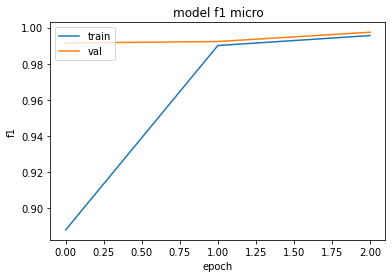

In [33]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
results_table.loc[results_table.shape[0]] = ['bert-base-multilingual-cased', str(num_epochs), str(f1s_eval[-1])]
results_table

,model,num_epochs,F1
0,DeepPavlov/rubert-base-cased,3,0.996575
1,xlm-roberta-base,3,0.9948630136986302
2,bert-base-multilingual-cased,3,0.997431506849315


In [35]:
cleanup()

# Linear Models

In [36]:
import pandas as pd
import numpy as np
 
from collections import Counter
import re
 
import pymorphy2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
import statistics
import seaborn as sn
import matplotlib.pyplot  as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
 
from time import time
 
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

In [37]:
CLS_ALGORITHM_list = ['PassiveAggressiveClassifier','LogisticRegression', 'MultinomialNB', 'RandomForestClassifier']
 
text_column = 'text' 
df_train = df_train[['text', 'target']]
df_test = df_test[['text', 'target']]
df = pd.concat([df_train, df_test])
df = df[df['target'].isna()==False]
df = df[df['text'].isna()==False].reset_index()

def bt(token_pattern=r'(?u)\b\w\w+\b'):
    return re.compile(token_pattern).findall
tokenizer=bt()
print(tokenizer('привет как дела?'))
 
def tokenize_line(line):
    return [re.sub('_', ' ', str(w).lower()) for w in tokenizer(str(line))]
print(tokenize_line('привет_ как дела?'))
 

df['tokens'] = df[text_column].apply(lambda x : tokenize_line(x))
 
class Lemmatizer:
    def __init__(self):
        self.morph = pymorphy2.MorphAnalyzer()
       
    def __call__(self, x: str) -> str:
        lemma = self.morph.parse(x)[0].normal_form
        return lemma
     
lemmatizer = Lemmatizer()
 
 
def lemmatize_df(df, text_column):
    unique_toks = set([])
    for line in df[text_column]:
        for w in line:
            if w not in unique_toks:
                unique_toks.add(w)
    print('made unique tokens set')
    t_l = {}
    for ut in unique_toks:
        t_l[ut] = lemmatizer(ut)
    print('made tokens-lemmas dict')
    return unique_toks, t_l
 
unique_toks, t_l = lemmatize_df(df, 'tokens')
 
def lemmatize_line(t_l, line):
    return ' '.join([t_l[w] for w in line])
 
df['lemmas'] = df['tokens'].apply(lambda x: lemmatize_line(t_l, x))
 
 
def visualize(y_true, y_pred, df, target_column, new_path):
    plt.figure(figsize=(14,10))
    array=confusion_matrix(y_true, y_pred)
    a = [sorted(df[target_column].unique())]
    df_cm = pd.DataFrame(array, index=a, columns=a)
    sn.set(font_scale=1.2)
    sn.heatmap(df_cm, annot=True, annot_kws={'size':9}, cmap='Blues',fmt='g')
    plt.xticks(rotation=60)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Реальный класс')
    plt.savefig(new_path + '_'+ 'image.png')
    plt.show()

def examples(df, text_column, target_column, num_ex, orig_column):
    for cl in df[target_column].unique():
        print(f'-----{cl.upper()}----\n')
        for i, cl2 in enumerate(df[target_column].unique()):
            if cl != cl2:
                sl = list(df[(df[target_column] == cl) & (df['pred_column'] == cl2)][orig_column].unique())
                ex = '\n-'.join(sl[:num_ex])
                print(f"{i}) {cl} --> {cl2}: \n{ex}")
        print('\n\n')

def main(path, df, text_column, target_column,
         report=True, visualization=True,
         show_examples=True, num_ex=10, orig_column='same'):
   
    vars = []
    all_f1s = {}
    for CLS_ALGORITHM in CLS_ALGORITHM_list:
        path_save = path + '/' + CLS_ALGORITHM
        print(CLS_ALGORITHM, path_save)
        df_toans = cls_alg(CLS_ALGORITHM, df, text_column, target_column, path_save, er=True)
        if text_column!='lemmas' and text_column!='tokens':
            txt_col = 'orig'
        else:
            txt_col = text_column
        df_ans = df_toans
        
        ext = 'xlsx'
        
        new_path = path + '/' +f'annotated_{txt_col}_{CLS_ALGORITHM}.' + ext
        
        if ext == 'csv':
            df_ans.to_csv(new_path)
        else:
            df_ans.to_excel(new_path)
        print(f'new file is saved in {new_path}: \n predicted values are in "pred_column"')
        print('\n Final f-core on the whole dataset: \n')
        if report:
            print(classification_report(df_ans[target_column], df_ans['pred_column']))
        if visualization:
            print('\n  Visualization of classification')
            print(visualize(df_ans[target_column], df_ans['pred_column'], df_ans, target_column, new_path))
        if show_examples:
            if orig_column=='same':
                orig_column = text_column
            examples(df, text_column, target_column, num_ex, orig_column)
        vars.append(df_ans)

        f1s = f1_score(df_ans[target_column], df_ans['pred_column'])
        all_f1s[CLS_ALGORITHM] = f1s
        print(f1s)
    return pd.concat(vars), all_f1s
 
def cls_alg(CLS_ALGORITHM, df, text, target, path_save, er=True):
  
    skf = StratifiedKFold(n_splits=3, random_state=10, shuffle=True)
    indexes = []
    preds= []
    ys = []
 
    metrics = []
    d = {}
    X = df[text]
    y = df[target]
    if er:
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            y_test, predicted = text_cls(CLS_ALGORITHM, X_train,  y_train, X_test, y_test, path_save)
            preds.extend(predicted)
            ys.extend(y_test)
            metrics.append(f1_score(y_test, predicted, average='weighted'))
            for i,t in enumerate(y_test):
                d[t] = preds[i]
            indexes.extend(test_index)
 
        pred_column = ['-1'] * df.shape[0]
       
        for i, idx in enumerate(indexes):
            pred_column[idx] = preds[i]
        df['pred_column'] = pred_column
       
        
    print('List of possible Weighted F1:', metrics)
    print('\nMaximum Weighted F1 That can be obtained from this model is:',
              round(max(metrics)*100, 2), '%')
    print('\nMinimum Weighted F1:',
              round(min(metrics)*100, 2), '%')
    print('\nOverall Weighted F1:',
              round(np.mean(metrics)*100, 2), '%')
    print('\nStandard Deviation is:', statistics.stdev(metrics))
    df = df.drop(columns=['tokens', 'lemmas'])
   
    
    return df
 
 
def text_cls(CLS_ALGORITHM,X_train,  y_train, X_test, y_test, path_save):
    print(f"-----{CLS_ALGORITHM}-----")
    if CLS_ALGORITHM == 'LogisticRegression':
        nb =  Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf', LogisticRegression())])
        parameters_nb = {'vectorizer__ngram_range': [(1, 2), (2,2)],
                         'clf__penalty': ( "l1", "l2"),
                         'clf__C': (1.5, 1, 0.5),
                         'clf__class_weight': ['balanced']}
 
    elif CLS_ALGORITHM == 'MultinomialNB':
        nb = Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf',MultinomialNB())])
        parameters_nb = {'vectorizer__ngram_range': [(1, 2), (2,2)],
               'clf__alpha': ( 0.01, 0.001)}
    elif CLS_ALGORITHM == 'RandomForestClassifier':  
        nb = Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf', RandomForestClassifier())])
 
 
        parameters_nb = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
               'clf__class_weight': ("balanced", "balances_subsample")}
    elif CLS_ALGORITHM == 'PassiveAggressiveClassifier':
        nb = Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                     smooth_idf=True,
                                                     sublinear_tf=True)),
                      ('clf', PassiveAggressiveClassifier())])
        parameters_nb = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
                        'clf__max_iter': (100, 500, 1000)}
             
    gs_clf_nb = GridSearchCV(nb, parameters_nb, n_jobs=-1, scoring = "f1_weighted")
 
   
    gs_clf_nb = gs_clf_nb.fit(X_train.to_list(), y_train.to_list())
    print('best score --- ', gs_clf_nb.best_score_)
    print('best parameters --- ', gs_clf_nb.best_params_)
    r = gs_clf_nb.best_estimator_
    predicted = r.predict(X_test.to_list())
    joblib.dump(r, f'{path_save}_{CLS_ALGORITHM}.pkl')
    return y_test, predicted

['привет', 'как', 'дела']
['привет ', 'как', 'дела']
made unique tokens set
made tokens-lemmas dict


PassiveAggressiveClassifier ../results/PassiveAggressiveClassifier
-----PassiveAggressiveClassifier-----
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- E

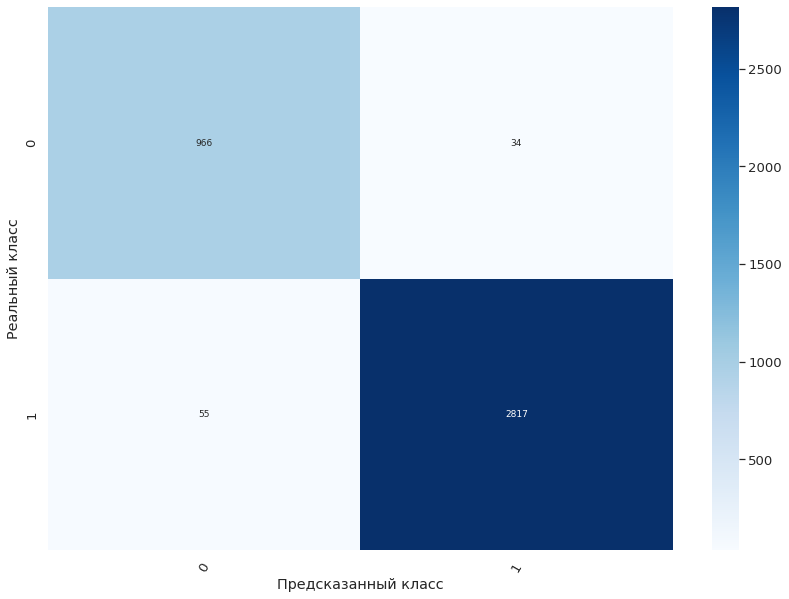

None
0.9844487157085444
LogisticRegression ../results/LogisticRegression
-----LogisticRegression-----
best score ---  0.9661704669771766
best parameters ---  {'clf__C': 1.5, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'vectorizer__ngram_range': (1, 2)}
-----LogisticRegression-----
best score ---  0.966087104703617
best parameters ---  {'clf__C': 1.5, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'vectorizer__ngram_range': (1, 2)}
-----LogisticRegression-----
best score ---  0.9641367995138953
best parameters ---  {'clf__C': 1.5, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'vectorizer__ngram_range': (1, 2)}
List of possible Weighted F1: [0.9761992768623663, 0.961360564288558, 0.966547080017726]

Maximum Weighted F1 That can be obtained from this model is: 97.62 %

Minimum Weighted F1: 96.14 %

Overall Weighted F1: 96.8 %

Standard Deviation is: 0.007530518355163073
new file is saved in ../results/annotated_lemmas_LogisticRegression.xlsx: 
 predicted values

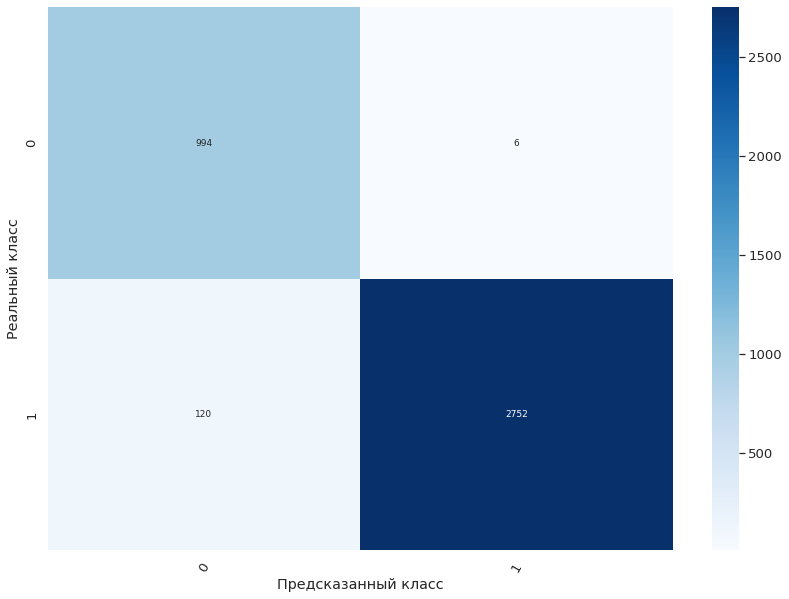

None
0.977619893428064
MultinomialNB ../results/MultinomialNB
-----MultinomialNB-----
best score ---  0.9847765621957258
best parameters ---  {'clf__alpha': 0.01, 'vectorizer__ngram_range': (1, 2)}
-----MultinomialNB-----
best score ---  0.9820338239964205
best parameters ---  {'clf__alpha': 0.01, 'vectorizer__ngram_range': (1, 2)}
-----MultinomialNB-----
best score ---  0.9823614924115113
best parameters ---  {'clf__alpha': 0.01, 'vectorizer__ngram_range': (1, 2)}
List of possible Weighted F1: [0.9820490001408302, 0.9851858216143143, 0.9844021853158279]

Maximum Weighted F1 That can be obtained from this model is: 98.52 %

Minimum Weighted F1: 98.2 %

Overall Weighted F1: 98.39 %

Standard Deviation is: 0.001632544806564578
new file is saved in ../results/annotated_lemmas_MultinomialNB.xlsx: 
 predicted values are in "pred_column"

 Final f-core on the whole dataset: 

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1000
        

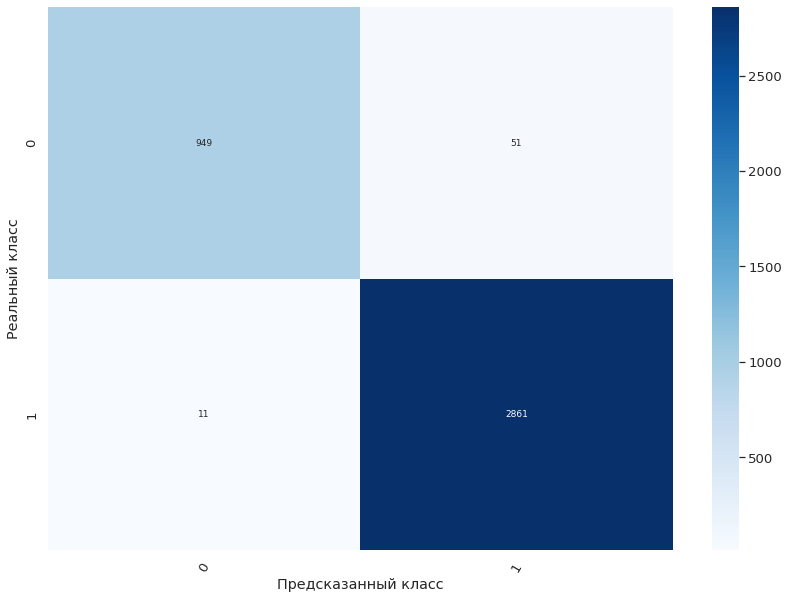

None
0.989280774550484
RandomForestClassifier ../results/RandomForestClassifier
-----RandomForestClassifier-----
best score ---  0.9415475035102894
best parameters ---  {'clf__class_weight': 'balanced', 'vectorizer__ngram_range': (1, 1)}
-----RandomForestClassifier-----
best score ---  0.9363737122074266
best parameters ---  {'clf__class_weight': 'balanced', 'vectorizer__ngram_range': (1, 1)}
-----RandomForestClassifier-----
best score ---  0.938653729926757
best parameters ---  {'clf__class_weight': 'balanced', 'vectorizer__ngram_range': (1, 1)}
List of possible Weighted F1: [0.9421767958217987, 0.9492290486073459, 0.9449199357207576]

Maximum Weighted F1 That can be obtained from this model is: 94.92 %

Minimum Weighted F1: 94.22 %

Overall Weighted F1: 94.54 %

Standard Deviation is: 0.003554985694436295
new file is saved in ../results/annotated_lemmas_RandomForestClassifier.xlsx: 
 predicted values are in "pred_column"

 Final f-core on the whole dataset: 

              precision 

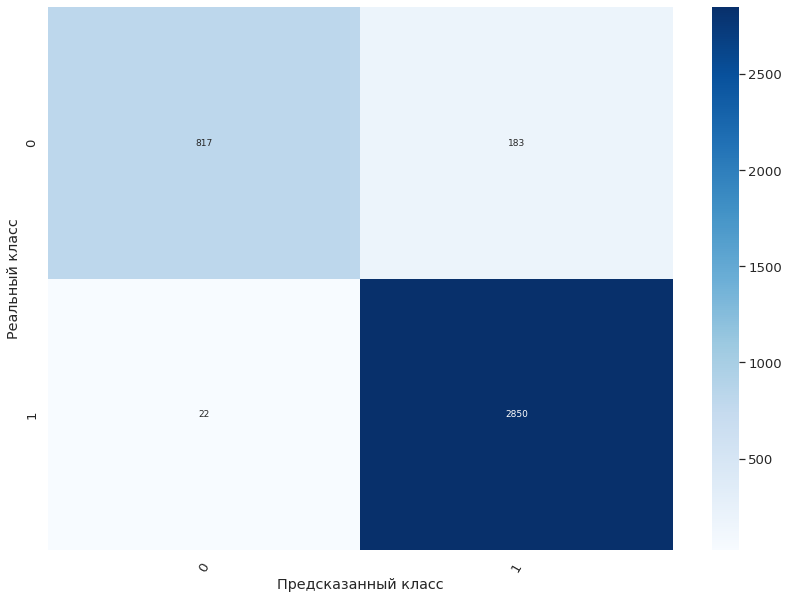

None
0.9652836579170195


In [38]:
path = '../results'
new_df, f1s = main(path, df=df, text_column='lemmas', target_column='target',
         report=True, visualization=True,
         show_examples=False, num_ex=10, orig_column='same')

In [39]:
pd.DataFrame({'model': list(f1s.keys()), 'F1 score': [f1s[k] for k in list(f1s.keys())]})

,model,F1 score
0,PassiveAggressiveClassifier,0.984449
1,LogisticRegression,0.977620
2,MultinomialNB,0.989281
3,RandomForestClassifier,0.965284


In [40]:
CLS_ALGORITHM = 'MultinomialNB'

nb = Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf',MultinomialNB())])
parameters_nb = {'vectorizer__ngram_range': [(1, 2), (2,2)],
               'clf__alpha': ( 0.01, 0.001)}
             
gs_clf_nb = GridSearchCV(nb, parameters_nb, n_jobs=-1, scoring = "f1_weighted")
 
   
gs_clf_nb = gs_clf_nb.fit(df_train['text'].to_list(), df_train['target'].to_list())
print('best score --- ', gs_clf_nb.best_score_)
print('best parameters --- ', gs_clf_nb.best_params_)
r = gs_clf_nb.best_estimator_
predicted = r.predict(df_test['text'].to_list())
print(classification_report(df_test['target'], predicted))
joblib.dump(r, f'../models/{CLS_ALGORITHM}.pkl')

best score ---  0.9737718865638187
best parameters ---  {'clf__alpha': 0.01, 'vectorizer__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       300
           1       0.98      0.99      0.98       861

    accuracy                           0.98      1161
   macro avg       0.97      0.96      0.97      1161
weighted avg       0.97      0.98      0.97      1161



['../results/MultinomialNB.pkl']

In [41]:
CLS_ALGORITHM = 'MultinomialNB'
best_model = joblib.load(f'../models/{CLS_ALGORITHM}.pkl')
best_model.predict_proba(['привет как дела',
                          'в целях обеспечения безопасности департамента',
                         'распоряжение о запрете передачи карточных данных сторонним организациям'])

array([[9.65842370e-01, 3.41576300e-02],
       [7.30769131e-04, 9.99269231e-01],
       [4.37632619e-03, 9.95623674e-01]])

In [42]:
best_model.predict_proba(['привет как дела',
                          'в целях обеспечения безопасности департамента',
                         'распоряжение о запрете передачи карточных данных сторонним организациям']).argmax(axis=1)

array([0, 1, 1])